In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
import sys
import pathlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import json



%matplotlib inline  

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [4]:
# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS.csv.gz")

# Load expression data 
with open("outputs/HeLa_SABER_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# subset the profiles to only expressed genes
gene_list = express['expressed_genes']
df_genes = df_guide[(df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(gene_list))]

# Create a dattaframe of only features without metadata
feature_df = df_genes.drop(['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'],axis = 1).reset_index(drop=True)
feature_df

,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,...,Nuclei_Texture_SumEntropy_PRSP6_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_Syto9_10_03_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
0,0.086527,-0.161330,0.573750,0.141280,-0.007252,0.040078,-0.080994,-0.133670,-0.395330,0.345020,...,0.120900,-0.44926,-0.551010,-0.277160,-0.455090,-0.285150,0.126290,-0.015295,0.283320,-0.330710
1,0.001845,-0.013965,-0.283930,-0.170340,-0.015979,-0.000368,0.044906,0.025195,0.113290,-0.044236,...,-0.556010,-0.33746,-0.223580,-0.566860,-0.432120,-0.310720,-0.030054,0.135890,0.109810,-0.299660
2,0.018373,0.065975,0.041582,-0.201310,-0.041717,-0.009325,-0.021793,0.019012,0.023703,0.133580,...,-0.545920,-0.27065,-0.130940,-0.216200,-0.315280,-0.522770,0.179890,0.044213,0.154610,-0.265570
3,-0.060312,-0.185300,0.281040,-0.228630,0.058907,-0.028427,0.373800,0.009485,-0.410520,0.442700,...,-0.380730,-0.29043,-0.407430,-0.581920,-0.395970,-0.533260,0.196140,0.124090,0.116250,-0.294630
4,0.083596,-0.201250,-0.061307,0.324740,0.334370,0.362300,0.030412,-0.006410,0.989080,-0.454970,...,0.153160,-0.34373,-0.565310,-0.418010,-0.610970,-0.472160,-0.203830,-0.148970,0.205870,-0.211310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,-0.212220,0.067546,-0.227800,-0.399800,0.202580,-0.129730,-0.002903,-0.094863,0.326800,-0.124720,...,-0.298020,-0.41298,-0.017322,0.385270,0.503560,0.212660,-0.137590,-0.332410,-0.028615,0.173370
2192,-0.673420,0.341320,1.268300,0.620520,0.386450,0.599320,0.596940,0.383800,-2.080300,1.818900,...,3.202300,2.63940,3.254000,3.066900,3.283000,2.898800,-0.195570,1.705200,0.002321,2.493100
2193,0.001845,0.047350,0.547330,-0.010489,0.684260,-0.065428,-0.072954,0.062614,-0.028035,-0.397480,...,0.565520,0.28315,0.246110,0.383230,0.188570,0.486640,-0.471750,0.102350,-0.119970,0.061642
2194,0.018373,0.855010,0.538510,-0.372040,-0.250900,-0.147310,0.143530,-0.000957,-0.029339,0.026961,...,-0.041265,0.12624,-0.118190,-0.456900,-0.392630,-0.512970,0.075881,-0.009450,-0.082326,-0.281200


In [6]:
n_features = 2196#len(feature_df.columns)
model = PCA(n_components = n_features).fit(feature_df)
X_pc = model.transform(feature_df)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component

initial_feature_names = list(feature_df.columns)

most_important = {}
for i in range(n_pcs):
    temp = np.abs(model.components_[i]).argsort()
    temp = temp[::-1] 
    most_important['PC{}'.format(i+1)] = [{initial_feature_names[temp[j]]: np.abs(model.components_[i])[temp[j]]} for j in range(n_features)]
    

len(most_important)

2196

In [7]:
ratios = model.explained_variance_ratio_
feature_dic = {}
for count, key in enumerate(most_important.keys()):
    for c, k in enumerate(most_important[key]):
        value = list(k.values())[0] * ratios[count]
        if list(k.keys())[0] in feature_dic.keys():
            feature_dic[list(k.keys())[0]].append(value)
        else:
            feature_dic[list(k.keys())[0]] = [value]
len(feature_dic)

3072

In [8]:
feature_scores = {}
added_values = 0
for feature in feature_dic.keys():
    feature_scores[feature] = sum(feature_dic[feature])
    added_values += sum(feature_dic[feature])
print(added_values)

feature_scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')
len(feature_scores)

40.4647355712308


3072

In [9]:
feature_scores_df.sort_values(0,ascending = False).tail(10)

,0
Nuclei_Granularity_11_ConA,0.002935
Cells_AreaShape_CentralMoment_2_3,0.002921
Cytoplasm_Granularity_12_WGA,0.002850
Nuclei_AreaShape_HuMoment_4,0.002731
Cells_AreaShape_CentralMoment_1_3,0.002687
Cytoplasm_Granularity_12_Syto9,0.002628
Cytoplasm_AreaShape_CentralMoment_2_3,0.002376
Nuclei_AreaShape_HuMoment_6,0.002312
Nuclei_Granularity_11_LAMP1,0.002181
Cells_AreaShape_HuMoment_6,0.000696


In [13]:
feature_scores_df.sort_values(0,ascending = False).head(100)

,0
Cells_Correlation_Correlation_Syto9_TDP43,0.017328
Cytoplasm_Correlation_Correlation_DNA_WGA,0.017261
Nuclei_Correlation_K_COXIV_WGA,0.017234
Cells_Correlation_Correlation_COXIV_WGA,0.017211
Cells_Correlation_Overlap_G3BP1_TDP43,0.017142
...,...
Cytoplasm_Texture_InverseDifferenceMoment_WGA_20_01_256,0.016308
Cytoplasm_Correlation_Correlation_COXIV_Phalloidin,0.016299
Nuclei_Correlation_K_WGA_COXIV,0.016299
Cytoplasm_Correlation_Overlap_COXIV_Catalase,0.016293


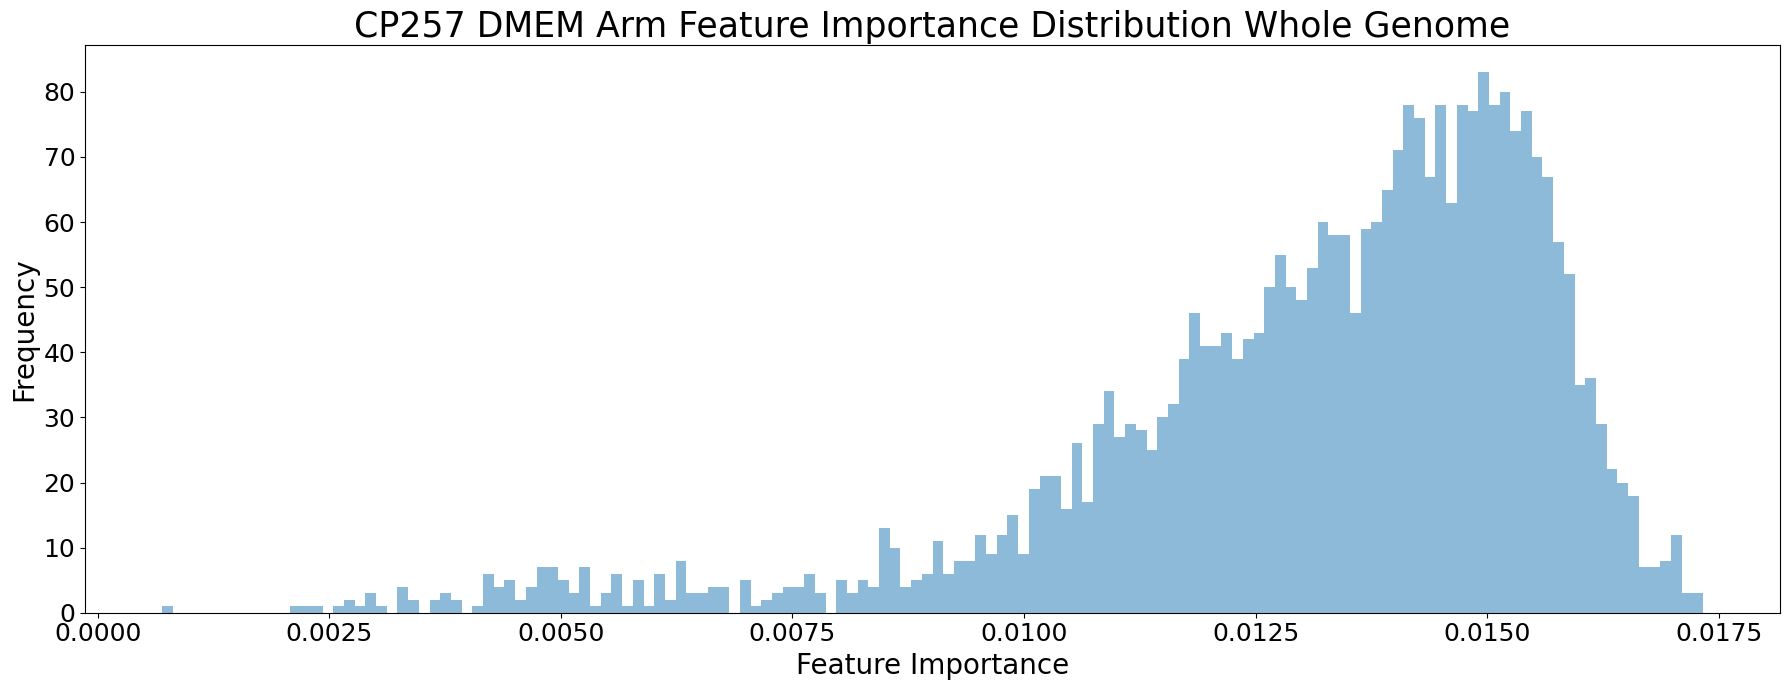

In [11]:
fig, ax = plt.subplots(figsize=(18,7))

feature_scores_df.plot.hist(bins=int(576/4),color='tab:blue',alpha=0.5,ax=ax)


ax.set_title('CP257 DMEM Arm Feature Importance Distribution Whole Genome', fontdict= {'fontsize':25})
ax.set_xlabel('Feature Importance', fontdict= {'fontsize':20})
plt.xticks(fontsize=18)
ax.set_ylabel('Frequency', fontdict= {'fontsize':20})
plt.yticks(fontsize=18)
ax.get_legend().remove()
plt.tight_layout()
#ax.figure.savefig('cp257_dmem_feature_variation_importance_distribution_whole_genome.png', dpi=200,facecolor='w', edgecolor='w')
